# 卷積與池化的概念

## 簡單卷積

In [3]:
import numpy as np

# 設定隨機種子，確保每次執行產生的亂數都一樣（方便除錯）
np.random.seed(5)

# 產生一個包含 10 個元素的陣列，數值介於 1 到 30 之間，資料型態為長整數 (long)
x = np.random.randint(low=1, high=30, size=10, dtype='l')
print(x)

# 定義權重陣列（或是過濾器 Filter/Kernel）
w = np.array([1.2, 0.3, 0.5])

# 取得原始資料 x 的長度與權重 w 的長度
n = x.size
K = w.size

# 初始化一個全為 0 的陣列 z，用來存放計算結果
# 長度設定為 n-K+1 是為了確保滑動視窗不會超出邊界 (Valid Padding)
z = np.zeros(n-K+1)

# 開始跑迴圈進行滑動視窗計算
for i in range(n-K+1):
    # 取出 x 的子部分與權重 w 進行元素對應相乘後加總 (點積運算)
    z[i] = np.sum(x[i:i+K] * w)

# 輸出權重與最終計算出來的結果
print(w)
print(z)

[ 4 15 16  7 23 17 10  9  5  8]
[1.2 0.3 0.5]
[17.3 26.3 32.8 23.8 37.7 27.9 17.2 16.3]


## Same 與 Full 卷積

In [4]:
def conv1d(x, w, pad):
    # 取得輸入資料 x 的長度與權重 w (Kernel) 的長度
    n = x.size
    K = w.size

    # 計算總共要補零的數量（左右兩邊各補 pad 個 0）
    P = 2 * pad

    # 計算輸出陣列的長度 (公式：輸入長度 + 總填充 - 核心長度 + 1)
    n_o = n + P - K + 1

    # 初始化輸出陣列 y
    y = np.zeros(n_o)

    # 判斷是否需要進行 Padding
    if P > 0:
        # 建立一個補零後的新陣列，長度為原本長度加上 P
        x_pad = np.zeros(n + P)
        # 將原本的資料 x 塞進中間，避開頭尾需要補 0 的位置
        x_pad[pad:-pad] = x
    else:
        # 如果不需補零，直接使用原始資料
        x_pad = x

    # 開始執行滑動視窗運算
    for i in range(n_o):
        # 在補零後的陣列上，取出對應區段與權重相乘並加總
        y[i] = np.sum(x_pad[i:i + K] * w)

    return y

In [5]:
# 執行 Same 卷積：透過補 1 層零 (pad=1)，讓輸出的長度儘可能跟輸入一樣
y1 = conv1d(x, w, 1)
# 印出原始資料長度、權重長度以及計算後的長度
print(x.size, w.size, y1.size)
print("same: ", y1)

# 執行 Full 卷積：補上足夠的零 (pad=2)，讓權重只要「沾到邊」就開始計算
# 這會讓輸出的長度達到最大值 (n + K - 1)
y2 = conv1d(x, w, 2)
print(x.size, w.size, y2.size)
print("full: ", y2)

10 3 10
same:  [ 8.7 17.3 26.3 32.8 23.8 37.7 27.9 17.2 16.3  8.4]
10 3 12
full:  [ 2.   8.7 17.3 26.3 32.8 23.8 37.7 27.9 17.2 16.3  8.4  9.6]


In [6]:
def conv1d(x, w, pad=0, s=1): 
    # 取得輸入長度 n 與核心 (Kernel) 長度 K
    n = x.size
    K = w.size   
    
    # 計算輸出長度公式 (考慮 Stride 步長)
    # 使用 // 是整數除法，確保索引是整數
    n_o = (n + 2 * pad - K) // s + 1
    
    # 初始化用來存放卷積結果的陣列 y
    y = np.zeros(n_o)             
    
    # 處理填充 (Padding)
    if not pad == 0:
        # 使用 np.pad 進行常數填充（預設補 0）
        # [(pad, pad)] 代表在陣列的前後各補 pad 個元素
        x_pad = np.pad(x, [(pad, pad)], mode='constant')
    else:
        # 若 pad 為 0 則直接使用原資料
        x_pad = x
    
    # 開始跑迴圈，逐一掃描計算結果
    for i in range(n_o): 
        # 計算視窗的起點：將索引 i 乘以步長 s
        # 這裡執行 Element-wise 相乘與加總
        y[i] = np.sum(x_pad[i*s : i*s + K] * w)            
        
    return y

In [7]:
y0 = conv1d(x, w, 0) 
y1 = conv1d(x, w, 0, s=2)    
y2 = conv1d(x, w, 1, s=2)  
print(y0)
print(y1)
print(y2)

[17.3 26.3 32.8 23.8 37.7 27.9 17.2 16.3]
[17.3 32.8 37.7 17.2]
[ 8.7 26.3 23.8 27.9 16.3]


## 一維卷積

以下展示的在一維數列上所謂卷積的概念，可以藉由卷積來轉換資料，去除雜訊、獲取特定資料的特徵都常以這樣的方式來進行。

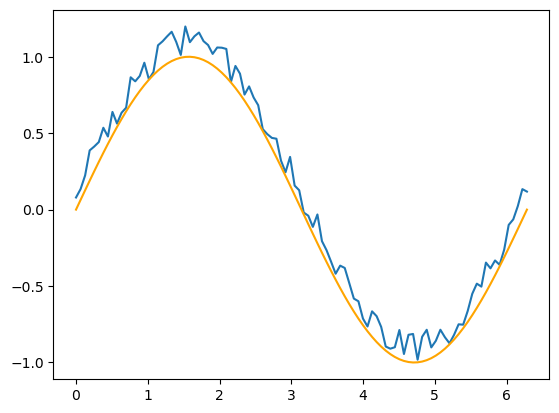

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 在 0 到 2π 之間產生 100 個均勻分布的點
x = np.linspace(0, 2 * np.pi, 100)

# 產生正弦波，並加上隨機雜訊
# np.random.random(100) 會產生 0 到 1 之間的浮點數
# 乘以 0.2 是為了把雜訊的振幅縮小，讓它看起來像是「抖動」
y = np.sin(x) + np.random.random(100) * 0.2
y_unbias = np.sin(x)

# 呼叫 Matplotlib 畫出折線圖
plt.plot(x, y)
plt.plot(x, y_unbias, color='orange')

# 顯示圖表
plt.show()

以下使用在訊號處理與影像處理中極其重要的一維高斯函數（1D Gaussian Function）建立高斯權重 (Gaussian weights) 可以對雜訊訊號進行平滑化 (Smoothing)。

計算權重 $w$ 的數學表達式如下：$$w = e^{-\frac{x^2}{2\sigma^2}}$$

常態分配機率分布函數和它類似：$$f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{x^2}{2\sigma^2}}$$

高斯分佈的特性：發現中間（$x=0$ 附近）的權重最高，越往兩邊越低。這代表在做卷積時，距離中心點越近的資料會給予較大的權重，而離得越遠的權重越小，這也就是降低雜訊的概念。

這個整數序列為 x_for_w: [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5]
['0.00', '0.00', '0.01', '0.05', '0.12', '0.20', '0.23', '0.20', '0.12', '0.05', '0.01', '0.00']


<BarContainer object of 12 artists>

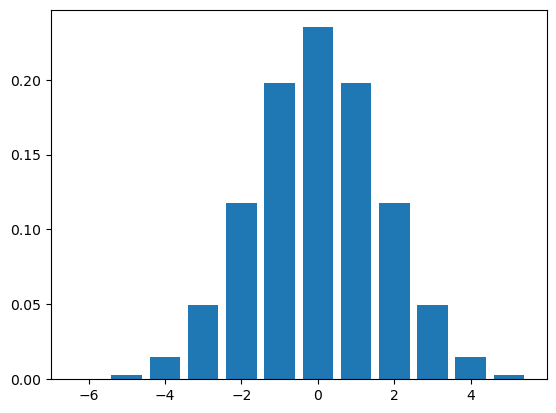

In [9]:
# 設定標準差 (Sigma)，這決定了高斯曲線（又稱常態分佈曲線或鐘形曲線）的寬度（也就是模糊的程度）
sigma = 1.6986436005760381

# 產生一個從 -6 到 5 的整數序列，作為權重的 x 軸座標
x_for_w = np.arange(-6, 6)
print("這個整數序列為 x_for_w:", x_for_w)

# 根據高斯函數公式計算對應的權重 y 值 (未歸一化)
# 公式：exp(-x^2 / (2 * sigma^2))
w = np.exp(-(x_for_w) ** 2 / (2 * sigma ** 2))

# 歸一化 (Normalization)：確保所有權重的總和等於 1
# 這樣卷積後的數值才不會被無故放大或縮小
w = w / sum(w)

# 以兩位小數的格式印出每個權重值，方便觀察數值分佈
print(["%0.2f" % x for x in w])

# 使用長條圖 (Bar Chart) 視覺化這個高斯分佈
plt.bar(x_for_w, w)

接下來則以前面產生的高斯函數權重 w，使用 np.correlate 執行互相關運算（在對稱權重下，結果等同於卷積）。

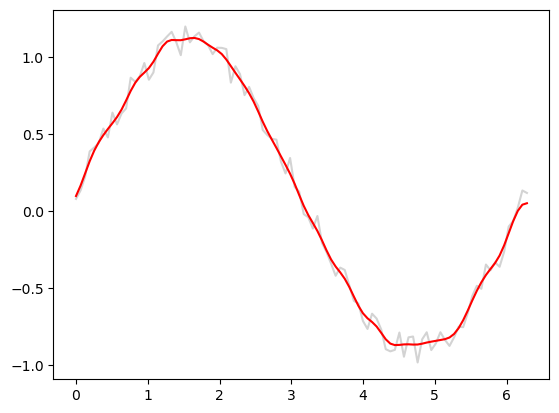

In [10]:
# 原本註解掉的 w 是簡單的權重，這個可以用來測試如果沒有經過高斯函數處理的話，結果會是什麼樣子
# w = np.array([0.1, 0.2, 0.5, 0.2, 0.1])

# 以高斯函數權重 w 對原始資料 y 進行卷積運算
# mode="same" 代表輸出長度會與輸入 y 一致，內部會自動處理 Padding
# yhat 代表預測值或平滑後的結果（hat 在統計學中常用來表示估計值）
yhat = np.correlate(y, w, "same")

# 將平滑後的結果畫出來，並設定為紅色以便區隔，原來的曲線則以淺灰色顯示作為對比
plt.plot(x, y, color='lightgray')
plt.plot(x, yhat, color='red')

In [11]:
a = np.array([1, 2, 55, 4, 5])
w = np.array([0.2, 0.5, 0.2])
y = np.correlate(a, w, "same")
print(y)

[ 0.9 12.2 28.7 14.   3.3]


## 二維卷積

以下用數位影像作為範例，描述二維卷積的運作原理。

首先說明什麼是數位影像，一般的數位影像是由 n x n 的像素陣列所組成，如果帶有色彩，則可以視為有 RGB 三個色彩通道的圖片組成，若有透明度，則可以有 A 的透明度通道。之後的說明則是將彩色圖片轉為僅有 n x n 的灰階圖片來進行。

Text(0.5, 1.0, 'Grayscale Image')

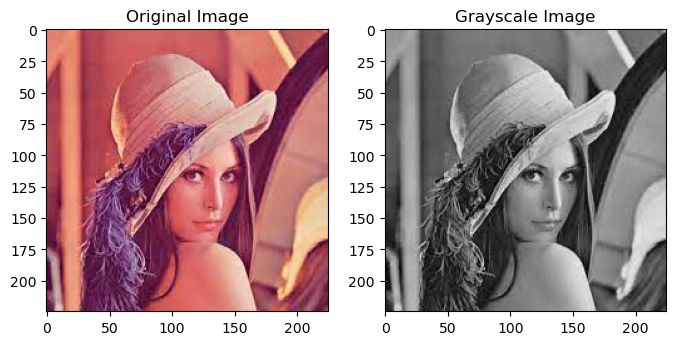

In [ ]:
from skimage import io, transform
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline

img = io.imread('Image/lena.jpg')
gray_img = rgb2gray(img) 

# 設定畫布，準備顯示 1 列 2 欄的子圖
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

# 在左側子圖顯示原始彩色影像
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

# 在右側子圖顯示灰階影像，並指定使用灰階色階 (colormap)
plt.subplot(1, 2, 2)
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")

In [13]:
import numpy as np

# 印出影像矩陣的維度 (Shape)
# 彩色影像通常是 (高, 寬, 3)，灰階則是 (高, 寬)
print('原始影像矩陣維度: ', img.shape)
print('灰階影像矩陣維度: ', gray_img.shape)

# 取出特定範圍的像素值來觀察 (切片操作)
# 這裡取出第 150 到 155 列、第 110 到 115 欄的數值
# 特別需要注意的是，灰階色彩的數值範圍為 0 到 1 之間的浮點數，而彩色影像的 RGB 三通道則是 0 到 255 的整數值
print('\n彩色影像矩陣的部分區塊數值 (RGB 三通道): \n', img[150:155, 110:115])
print('\n灰階影像矩陣的部分區塊數值 (單一數值): \n', gray_img[150:155, 110:115])

# 將正規化 (0~1) 的灰階數值還原回 0~255 的範圍
gray_img2 = gray_img * 255

# 將資料型態轉換為 8 位元無符號整數 (uint8)
# 這是標準影像格式最常用的資料型態
gray_imgs = gray_img2.astype(np.uint8)

# 印出轉換後，灰階矩陣特定區塊的像素值 (現在數值會是 0~255 的整數)
print('灰階矩陣的部分區塊數值 (uint8 格式): \n', gray_imgs[150:155, 110:115])

原始影像矩陣維度:  (225, 225, 3)
灰階影像矩陣維度:  (225, 225)

彩色影像矩陣的部分區塊數值 (RGB 三通道): 
 [[[223 104 110]
  [225 106 112]
  [224  99 103]
  [225 100 104]
  [226 101 105]]

 [[224 103 108]
  [224 105 111]
  [224  98 102]
  [225  99 103]
  [225 100 104]]

 [[224 103 108]
  [224 105 111]
  [223  97 101]
  [222  96 100]
  [228 103 107]]

 [[223 102 107]
  [224 103 108]
  [233 108 112]
  [228 103 107]
  [227 102 106]]

 [[223 100 103]
  [222 101 106]
  [235 112 115]
  [231 108 111]
  [229 106 109]]]

灰階影像矩陣的部分區塊數值 (單一數值): 
 [[0.50870627 0.51654941 0.49353294 0.49745451 0.50137608]
 [0.50616863 0.51262784 0.49044471 0.49436627 0.49745451]
 [0.50616863 0.51262784 0.48652314 0.48260157 0.50921922]
 [0.50224706 0.50616863 0.52882706 0.50921922 0.50529765]
 [0.4955051  0.49832549 0.54256392 0.52687765 0.51903451]]
灰階矩陣的部分區塊數值 (uint8 格式): 
 [[129 131 125 126 127]
 [129 130 125 126 126]
 [129 130 124 123 129]
 [128 129 134 129 128]
 [126 127 138 134 132]]


## 二維卷積運算

這裡的程式碼主要是用來讀取一張彩色影像，將它轉換成灰階影像，並且觀察兩者在特定區塊的像素值。最後還將灰階影像的數值從 0~1 的浮點數轉換回 0~255 的整數格式，以符合一般影像處理的標準。

In [14]:
def convolve2d(X, K): 
    # 取得卷積核（Kernel）的高與寬
    h, w = K.shape
    
    # 初始化輸出矩陣 Y（大小為：輸入尺寸 - Kernel尺寸 + 1）
    # 這是為了存放卷積運算後的結果
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    
    # 透過巢狀迴圈進行滑動視窗運算
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):           
            # 1. 擷取輸入影像中與 Kernel 大小相同的區域 (Sub-matrix)
            # 2. 與 Kernel 進行逐元素相乘 (Element-wise multiplication)
            # 3. 將所有乘積加總，得到輸出矩陣中該位置的數值
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum() 
            
    return Y

In [15]:
# 手動建立一個 6x6 的輸入矩陣 X (模擬一張微型影像)
X = np.array([[2,3,0,7,9,5], [6,0,4,7,2,3], [8,1,0,3,2,6],
             [7,6,1,5,2,8], [9,5,1,8,3,7], [2,4,1,8,6,5]])

# 定義一個 3x3 的卷積核 K (這是一個典型的 Sobel 垂直邊緣偵測濾波器)
K = np.array([[-1, 0, 1],
              [-2, 0, 2],
              [-1, 0, 1]])

print("輸入矩陣 X: \n", X)
print("卷積核 K: \n", K)

# 執行卷積運算
# 因為 X 是 6x6，K 是 3x3，且沒有 Padding
# 所以輸出的矩陣大小會是 (6-3+1) x (6-3+1) = 4x4
result = convolve2d(X, K)
print("卷積運算結果: \n", result)
print("卷積運算結果的維度: ", result.shape)

輸入矩陣 X: 
 [[2 3 0 7 9 5]
 [6 0 4 7 2 3]
 [8 1 0 3 2 6]
 [7 6 1 5 2 8]
 [9 5 1 8 3 7]
 [2 4 1 8 6 5]]
卷積核 K: 
 [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
卷積運算結果: 
 [[-14.  20.   7.  -7.]
 [-24.  10.   3.   5.]
 [-28.   3.   6.   8.]
 [-23.   9.  10.  -2.]]
卷積運算結果的維度:  (4, 4)


影像的某個區域值： [[0.50870627 0.51654941 0.49353294 0.49745451 0.50137608]
 [0.50616863 0.51262784 0.49044471 0.49436627 0.49745451]
 [0.50616863 0.51262784 0.48652314 0.48260157 0.50921922]
 [0.50224706 0.50616863 0.52882706 0.50921922 0.50529765]
 [0.4955051  0.49832549 0.54256392 0.52687765 0.51903451]]


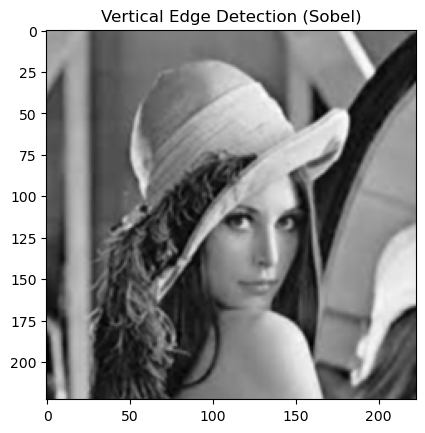

原始影像大小： (225, 225)
處理後影像大小： (223, 223)


In [16]:
# 將剛才處理好的灰階影像指定給變數 image
image = gray_img
print("影像的某個區域值：", image[150:155, 110:115])

# 定義卷積核 (Kernel)：這是一個垂直方向的 Sobel 算子
# 用來偵測影像中「左右亮度差異」明顯的地方，也就是垂直線條
# kernel = np.array([[-1, 0, 1],
#                    [-2, 0, 2],
#                    [-1, 0, 1]])

# 定義一個銳化 (Sharpening) 的卷積核
# 這個核會強調中心像素的亮度，並減弱周圍像素的亮度，從而讓影像看起來更銳利
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# 定義一個標準的 3x3 高斯卷積核
# 數值是根據高斯公式計算後，再進行歸一化 (Normalization)
kernel_gaussian = np.array([[1, 2, 1],
                            [2, 4, 2],
                            [1, 2, 1]]) / 16  # 除以 16 是為了讓權重總和等於 1

# 執行二維卷積運算
# 實務上這會提取出影像的邊緣特徵
image_sharpen = convolve2d(image, kernel_gaussian)

# 使用 Matplotlib 呈現處理後的結果
# cmap=plt.cm.gray 確保以灰階色調顯示
plt.imshow(image_sharpen, cmap=plt.cm.gray)
plt.title("Vertical Edge Detection (Sobel)")
plt.show()

# 印出運算前後的影像維度 (Shape)
# 由於沒有加上 Padding，結果影像的高寬都會縮減 (Kernel尺寸 - 1) 個像素
print("原始影像大小：", image.shape)
print("處理後影像大小：", image_sharpen.shape)

### 避免圖片縮小的方法：進行圖片的外圍填充（Padding）

In [17]:
import numpy as np

# 第一部分：手動實作 Padding
# 取得原始矩陣 X 的高 (H) 與 寬 (W)
H, W = X.shape
# 定義要在垂直方向 (P_h) 補 1 列，水平方向 (P_w) 補 2 欄
P_h, P_w = 1, 2

# 建立一個全為 0 的大矩陣，尺寸是原始大小加上外圍填充的寬度
# (H + 2*P_h) 代表上下各補 P_h；(W + 2*P_w) 代表左右各補 P_w
X_padded = np.zeros((H + 2*P_h, W + 2*P_w))   

# 透過索引切片 (Slicing)，將原始矩陣 X 放進大矩陣的正中央
# P_h:-P_h 表示避開上下邊界，P_w:-P_w 表示避開左右邊界
X_padded[P_h:-P_h, P_w:-P_w] = X

print(X_padded)

# ---

# 第二部分：使用 NumPy 內建函式 np.pad
a = np.array([[ 1.,  1.,  1.],
              [ 1.,  1.,  1.]])

# 使用 np.pad 進行填充
# [(1, 0), (1, 2)] 代表：
# 第一個維度（列）：上方補 1 列，下方補 0 列
# 第二個維度（欄）：左邊補 1 欄，右邊補 2 欄
# mode='constant' 預設就是補 0
b = np.pad(a, [(1, 0), (1, 2)], mode='constant')

print(a) # 印出原始陣列
print(b) # 印出填充後的陣列

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 3. 0. 7. 9. 5. 0. 0.]
 [0. 0. 6. 0. 4. 7. 2. 3. 0. 0.]
 [0. 0. 8. 1. 0. 3. 2. 6. 0. 0.]
 [0. 0. 7. 6. 1. 5. 2. 8. 0. 0.]
 [0. 0. 9. 5. 1. 8. 3. 7. 0. 0.]
 [0. 0. 2. 4. 1. 8. 6. 5. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0.]]


In [18]:
def convolve2d_same(X, K): 
    # 取得輸入矩陣 X 與卷積核 (Kernel) K 的高與寬
    H, W = X.shape   
    K_h, K_w = K.shape
   
    # 計算填充 (Padding) 的寬度，目的是為了讓卷積後的輸出尺寸與輸入相同 (Same Padding)
    # 這裡採用整數除法，通常卷積核為奇數（如 3x3），則上下左右各補 1 層
    P_h = (K_h) // 2         # 上下邊緣填充的高度
    P_w = (K_w) // 2         # 左右邊緣填充的寬度
    
    # 建立輸出矩陣 Y。
    # 關於你的疑問：np.zeros_like(X) 會出錯，通常是因為 X 的資料型別 (dtype) 為整數
    # 但卷積運算（加權總和）後常會產生浮點數，若 Y 強制跟隨 X 的型別會導致精確度遺失或報錯
    Y = np.zeros((H, W)) 
   
    # 使用 NumPy 內建函式進行填充，外圍補一圈 0
    X_padded = np.pad(X, [(P_h, P_h), (P_w, P_w)], mode='constant')    

    # 進行雙重迴圈跑滑動視窗 (Sliding Window)
    for i in range(Y.shape[0]):  
        for j in range(Y.shape[1]):
            # 擷取填充後矩陣中與卷積核大小相同的區域 (Region of Interest)
            # 與卷積核進行元素對應相乘 (Element-wise product) 後加總
            Y[i, j] = (X_padded[i:i+K_h, j:j+K_w] * K).sum()     
            
    return Y

原圖像大小： (225, 225)
結果圖像大小： (225, 225)


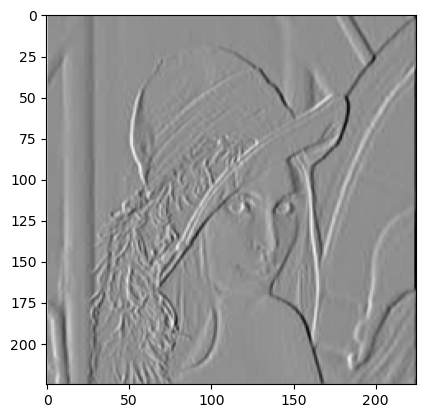

In [19]:
# 呼叫自定義的卷積函式處理影像
image = gray_img
# 定義 Sobel 卷積核 (用於偵測垂直邊緣)
# 這個 Kernel 會計算左右像素的差異，中間權重較大
kernel = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

# 進行「Same Padding」卷積運算，確保輸出影像尺寸不變
image_sharpen = convolve2d_same(image, kernel)

# 使用 Matplotlib 顯示結果，並指定為灰階顏色對照表 (Colormap)
plt.imshow(image_sharpen, cmap=plt.cm.gray)

# 印出處理前後的影像維度進行比對
print("原圖像大小：", image.shape)
print("結果圖像大小：", image_sharpen.shape)

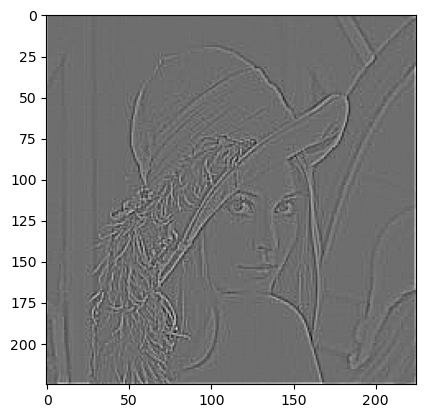

In [20]:
# 定義拉普拉斯卷積核 (Laplacian Kernel)
# 這種 Kernel 的特性是中心點權重極大 (8)，周圍權重為負 (-1)
# 它對影像中的「孤立點」或「細節邊緣」非常敏感
kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])

# 執行卷積運算，抓取影像中所有方向的邊緣線條
edges = convolve2d_same(image, kernel)

# 顯示偵測到的邊緣結果，並使用灰階顯示
# 注意：這類運算產生的數值可能很大或出現負數，Matplotlib 會自動調整顯示範圍
plt.imshow(edges, cmap=plt.cm.gray)

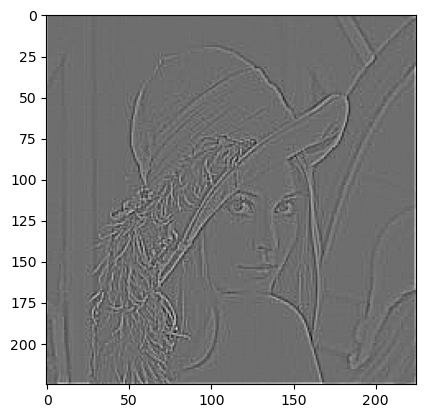

In [21]:
import scipy.signal
# 匯入 scipy 裡面的 signal 模組，主要用來做訊號與影像相關的運算

kernel = np.flipud(np.fliplr(kernel))   
# 將 kernel 先左右翻轉（fliplr），再上下翻轉（flipud）
# 這個動作常見於做 convolution 前，讓 kernel 符合數學定義

edges = scipy.signal.convolve2d(image, kernel, 'same')
# 使用 2D 卷積（convolution）對 image 與 kernel 進行運算
# 'same' 代表輸出影像大小會跟原本的 image 一樣

plt.imshow(edges, cmap=plt.cm.gray)
# 將卷積後的結果顯示成影像
# 使用灰階（gray）色彩對應，常用來看邊緣或特徵


[[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111]]


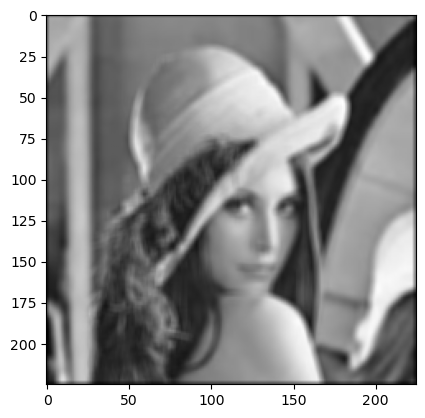

In [22]:
kernel = 1./9 * np.ones((5,5)) 
# 建立一個 5x5 的矩陣，元素全部都是 1
# 再乘上 1/9，通常用來當作平均（平滑）用的 kernel

print(kernel)
# 將 kernel 的內容印出來，方便確認數值是否正確

edges = convolve2d_same(image, kernel)
# 對影像 image 套用 2D 卷積運算
# 使用自訂的 convolve2d_same 函式，輸出大小與原影像相同

plt.imshow(edges, cmap=plt.cm.gray)
# 顯示卷積後的影像結果
# 使用灰階模式呈現，方便觀察平滑或邊緣效果


### 維持圖片大小的二維卷積函式

In [23]:
def convolve2d(X, K, pad=(0,0), stride=(1,1)): 
    # 定義 2D 卷積函式
    # X：輸入影像（2D array）
    # K：卷積用的 kernel
    # pad：padding 大小（上下、左右）
    # stride：stride 步長（垂直、水平）

    H, W = X.shape   
    # 取得輸入影像 X 的高度 H 與寬度 W

    K_h, K_w = K.shape
    # 取得 kernel 的高度與寬度
   
    P_h, P_w = pad
    # 取得上下與左右的 padding 大小

    S_h, S_w = stride  
    # 取得垂直與水平的 stride 步長
   
    h = (H - K_h + 2*P_h) // S_h + 1
    w = (W - K_w + 2*P_w) // S_w + 1    
    # 計算輸出影像的高度與寬度（依照卷積公式）

    Y = np.zeros((h, w)) 
    # 建立輸出影像矩陣，初始值全部為 0
   
    if P_h != 0 or P_w != 0:
        X_padded = np.pad(X, [(P_h, P_h), (P_w, P_w)], mode='constant') 
        # 如果有設定 padding，則在影像四周補 0
    else:
        X_padded = X
        # 若沒有 padding，直接使用原影像

    for i in range(Y.shape[0]):
        # 逐列掃描輸出影像
        hs = i * S_h
        # 計算在輸入影像中對應的起始高度位置

        for j in range(Y.shape[1]):
            # 逐行掃描輸出影像
            ws = j * S_w
            # 計算在輸入影像中對應的起始寬度位置

            Y[i, j] = (X_padded[hs:hs+K_h, ws:ws+K_w] * K).sum()
            # 擷取對應區塊與 kernel 做逐元素相乘後加總（卷積運算）

    return Y
    # 回傳卷積後的結果影像

In [24]:
X= np.array([[2,3,0,7,9,5], [6,0,4,7,2,3], [8,1,0,3,2,6],[7,6,1,5,2,8], [9,5,1,8,3,7], [2,4,1,8,6,5]])
convolve2d(X,K,(1,1),(2,2))

array([[ 6., 15., -8.],
       [ 8., 10.,  5.],
       [20.,  9., -2.]])

原始圖像大小： (225, 225)
結果圖像大小： (113, 113)


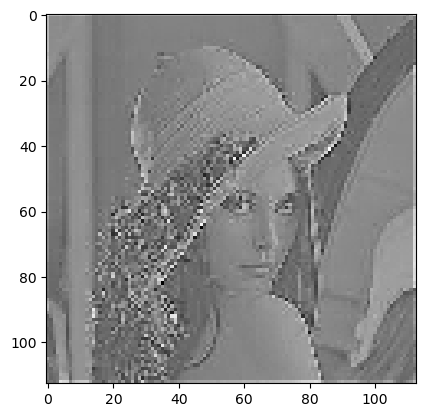

In [25]:
image = gray_img
# 將灰階影像指定給 image 變數，作為後續處理的輸入影像

kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
# 定義一個 3x3 的銳化（sharpening）kernel
# 中心值較大，用來加強影像邊緣與細節

image_filtered = convolve2d(image, kernel, (1,1), (2,2))
# 對影像進行 2D 卷積
# padding 設為 (1,1)，在影像四周補 0
# stride 設為 (2,2)，每次卷積視窗往右、往下各移動 2 個像素

plt.imshow(image_filtered, cmap=plt.cm.gray)
# 將卷積後的影像顯示出來
# 使用灰階模式方便觀察銳化效果

print("原始圖像大小：", image.shape)
# 印出原始影像的尺寸（高, 寬）

print("結果圖像大小：", image_filtered.shape)
# 印出經過卷積後影像的尺寸
# 可用來觀察 stride 與 padding 對輸出大小的影響

## 三維卷積

In [26]:
def convolve3d(X, K, P=(0,0), S=(1,1)): 
    # 定義 3D 卷積函式
    # X：輸入影像（shape 為 C x H x W）
    # K：卷積 kernel（shape 為 C x F_h x F_w）
    # P：padding 大小（上下、左右）
    # S：stride 步長（垂直、水平）

    C, H, W = X.shape
    # 取得輸入影像的通道數 C、高度 H、寬度 W

    C, F_h, F_w = K.shape
    # 取得 kernel 的通道數與 kernel 的高度、寬度
    # 這裡假設 kernel 的通道數與輸入影像相同

    P_h, P_w = P[0], P[1]
    # 取得上下與左右的 padding 大小

    S_h, S_w = S[0], S[1]   
    # 取得垂直與水平的 stride 步長
  
    h = (H + 2*P_h - F_h) // S_h + 1
    w = (W + 2*P_w - F_w) // S_w + 1
    # 根據輸入大小、kernel、padding 與 stride
    # 計算輸出影像的高度與寬度

    Y = np.zeros((h, w))            
    # 建立輸出影像矩陣，初始值設為 0
    # 這裡的輸出為單一通道（已將各通道加總）
   
    if P_h != 0 or P_w != 0:  
        # 如果有設定 padding，則在影像四周補 0
        # 每個 channel 都會一起做 padding
        X_padded = np.pad(X, [(0,0), (P_h,P_h), (P_w,P_w)], mode='constant')
    else:
        X_padded = X
        # 若沒有 padding，直接使用原影像
    
    for i in range(h):     
        # 逐列掃描輸出影像
        hs = i * S_h
        # 計算在輸入影像中對應的起始高度位置

        for j in range(w):   
            # 逐行掃描輸出影像
            ws = j * S_w
            # 計算在輸入影像中對應的起始寬度位置

            Y[i, j] = (K * X_padded[:, hs:hs+F_h, ws:ws+F_w]).sum()
            # 對所有 channel 做逐元素相乘後再全部加總
            # 這就是 3D 卷積（常見於 CNN 的 convolution layer）
        
    return Y
    # 回傳卷積後的 2D 輸出結果


In [27]:
X= np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]],
[[11, 12, 13], [14, 15, 16], [17, 18, 19]]])
K = np.array([[[1, 3], [2, 4]], [[4, -3], [2, 1]]])
convolve3d(X,K)

array([[ 86., 100.],
       [128., 142.]])

image matrix size:  (225, 225, 3)
(3, 225, 225)
(225, 225)


Text(0.5, 1.0, 'Edge Enhanced Image')

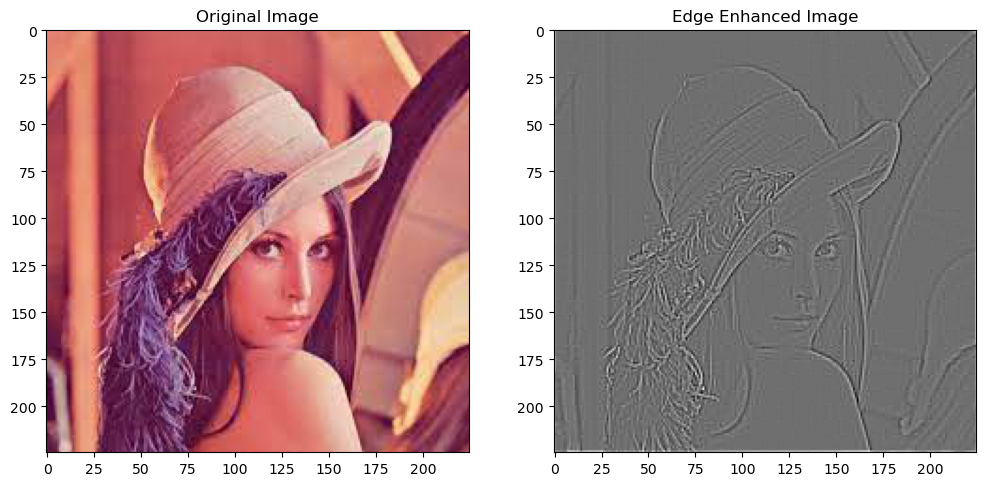

In [28]:
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 設定畫布，準備顯示 1 列 2 欄的子圖
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes.ravel()
# 將子圖陣列攤平成一維，方便後續存取
lenna_img = io.imread('Image/lena.jpg', as_gray=False)

# 在左側子圖顯示原始彩色影像
plt.subplot(1, 2, 1)
plt.imshow(lenna_img)
plt.title("Original Image")

print('image matrix size: ', lenna_img.shape)
# 印出影像矩陣大小，格式為 (高度, 寬度, 通道數)

X = np.moveaxis(lenna_img, -1, 0)
# 將影像的通道維度從最後一軸移到最前面
# 原本 shape 為 (H, W, C)，轉換成 (C, H, W)
# 這個格式較符合自訂 convolve3d 函式的輸入需求

kernel = np.array([[[-1,-1,-1],[-1,8,-1],[-1,-1,-1]],
                   [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]],
                   [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]])

edges = convolve3d(X, kernel, (1,1))
# 對彩色影像進行 3D 卷積
# padding 設為 (1,1)，避免輸出尺寸縮小
# 各 channel 的結果會在 convolve3d 中加總成單一輸出

print(X.shape)
print(edges.shape)

# 在右側子圖顯示卷積後的結果
# 使用灰階顯示邊緣效果
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap=plt.cm.gray)
plt.title("Edge Enhanced Image")

## 池化的概念

### 單通道的池化

In [ ]:
# 印出卷積後影像的維度，通常會是 (高度, 寬度)，因為 convolve3d 已經將通道加總了
# 參數包括卷積核大小、填充形式與池化輸出模式（最大池化或平均池化）
def pool2d(X, pool, stride=(1,1), padding=(0,0), mode='max'):
    pool_h, pool_w = pool          # 池化視窗的高度與寬度
    S_h, S_w = stride              # stride（步長）
    P_h, P_w = padding             # padding 大小
    
    # 填充（padding）
    if P_h or P_w:
        X_padded = np.pad(X, [(P_h, P_h), (P_w, P_w)], mode='constant')  # 以 0 補邊
    else:
        X_padded = X               # 不需要補邊就直接使用原矩陣
    
    # 計算輸出特徵圖大小
    Y_h, Y_w = (
        (X.shape[0] - pool_h + 2 * P_h) // S_h + 1,
        (X.shape[1] - pool_w + 2 * P_w) // S_w + 1
    )
    
    Y = np.zeros((Y_h, Y_w), dtype=X.dtype)  # 初始化輸出矩陣
    
    # 進行池化運算
    for i in range(Y.shape[0]):
        hs = i * S_h               # 高度方向起始位置
        for j in range(Y.shape[1]):
            ws = j * S_h           # 寬度方向起始位置
            if mode == 'max':      # 最大池化
                Y[i, j] = X[hs: hs + pool_h, ws: ws + pool_w].max()
            elif mode == 'avg':    # 平均池化
                Y[i, j] = X[hs: hs + pool_h, ws: ws + pool_w].mean()
    
    return Y                       # 回傳池化後結果

In [31]:
# 建立一個 6x6 的 numpy 陣列，當作輸入資料
X = np.array([
    [2, 3, 0, 7, 9, 5],
    [6, 0, 4, 7, 2, 3],
    [8, 1, 0, 3, 2, 6],
    [7, 6, 1, 5, 2, 8],
    [9, 5, 1, 8, 3, 7],
    [2, 4, 1, 8, 6, 5]
])

# 對輸入矩陣做 2D pooling
# (3,3)：pooling 視窗大小
# (3,3)：步長（stride）
# (0,0)：padding 大小
# mode='max'：使用最大值池化
maxpooling = pool2d(X, (3,3), (3,3), (0,0), mode='max')
print("Max Pooling Result:\n", maxpooling)

# 同樣的參數，但改成 mode='avg'，使用平均值池化
avgpooling = pool2d(X,(3,3),(3,3),(0,0),mode ='avg')
print("Average Pooling Result:\n", avgpooling)

Max Pooling Result:
 [[8 9]
 [9 8]]
Average Pooling Result:
 [[2 4]
 [4 5]]


### 多通道的池化

In [ ]:
def pool(X, pool, stride=(1,1), padding=(0,0), mode='max'):
    # 取得 pooling 視窗的高與寬
    pool_h, pool_w = pool

    # 取得 stride 的高與寬
    S_h, S_w = stride

    # 取得 padding 的高與寬
    P_h, P_w = padding
    
    # 如果有設定 padding，就在輸入資料外圍補 0
    if P_h or P_w:
        X_padded = np.pad(X, [(0,0), (P_h,P_h), (P_w,P_w)], mode='constant')
    else:
        # 沒有 padding 就直接使用原本資料
        X_padded = X
    
    # 計算輸出特徵圖的高與寬
    Y_h, Y_w = (
        (X.shape[1] - pool_h + 2*P_h) // S_h + 1,
        (X.shape[1] - pool_w + 2*P_w) // S_w + 1
    )
        
    # 建立輸出用的陣列
    Y = np.zeros((X.shape[0], Y_h, Y_w), dtype=X.dtype)

    # 印出輸入與輸出的 shape，方便除錯
    print(X.shape)
    print(Y.shape)
  
    # 依照 channel 一層一層做 pooling
    for c in range(Y.shape[0]):
        for i in range(Y.shape[1]):
            # 計算目前視窗在高度方向的起始位置
            hs = i * S_h
            for j in range(Y.shape[2]):
                # 計算目前視窗在寬度方向的起始位置
                ws = j * S_w
                if mode == 'max':
                    Y[c, i, j] = X[c, hs:hs+pool_h, ws:ws+pool_w].max()
                elif mode == 'avg':
                    Y[c, i, j] = X[c, hs:hs+pool_h, ws:ws+pool_w].mean()

    # 回傳 pooling 後的結果
    return Y

In [33]:
# 建立一個 3D numpy 陣列
# 第一維代表 channel（共有 2 個）
# 後兩維是每個 channel 的 3x3 資料
X3 = np.array([
    [[0, 1, 2], 
     [3, 4, 5], 
     [6, 7, 8]],

    [[11, 2, 3], 
     [4, 1, 16], 
     [71, 8, 9]]
])

# 印出原始輸入資料
print(X3)

# 對 X3 進行 pooling
# (2,2)：pooling 視窗大小
# (2,2)：stride 設為 2，每次跳 2 格
# (0,0)：不做 padding
# mode='max'：使用最大值池化
pool(X3, (2,2), (2,2), (0,0), mode='max')


[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[11  2  3]
  [ 4  1 16]
  [71  8  9]]]
(2, 3, 3)
(2, 1, 1)


array([[[ 4]],

       [[11]]])

(3, 225, 225)
(3, 111, 111)
原圖像大小： (3, 225, 225)
結果圖像大小： (111, 111, 3)


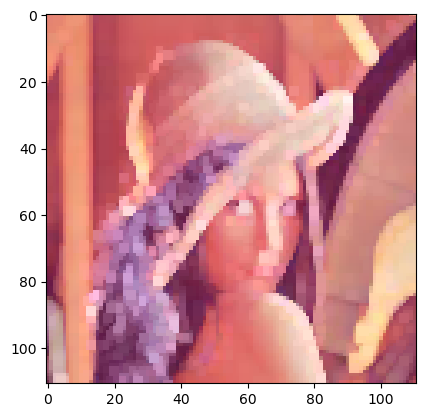

In [34]:
# 將影像的 channel 軸從最後一維移到最前面
# 例如 (H, W, C) 轉成 (C, H, W)，方便做 pooling
img = np.moveaxis(lenna_img, -1, 0)  # np.rollaxis(lenna_img, 2, 0)

# 對影像做 pooling
# [5,5]：pooling 視窗大小
# (2,2)：stride 設為 2
pooled_img = pool(img, [5,5], (2,2))

# 將 channel 軸再移回最後一維
# 由 (C, H, W) 轉回 (H, W, C)，方便顯示
pooled_img = np.moveaxis(pooled_img, 0, -1)

# 顯示 pooling 後的影像
plt.imshow(pooled_img, cmap=plt.cm.gray)

# 印出原始影像大小
print("原圖像大小：", img.shape)

# 印出 pooling 後影像大小
print("結果圖像大小：", pooled_img.shape)
